In [ ]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:

market_data = pd.read_parquet('data/US/test_mkt_data.pq')
dividends = pd.read_parquet('data/US/test_dividends.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_adv_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
close = market_data['close'].unstack().reindex_like(P)

In [ ]:
dividends = pd.read_parquet('data/US/test_dividends.pq')
dividends = dividends.dropna()
dividends['declarationDate'] = pd.to_datetime(dividends['declarationDate'])
dividends['paymentDate'] = pd.to_datetime(dividends['paymentDate'])
dividends['recordDate'] = pd.to_datetime(dividends['recordDate'])
dividends = dividends[dividends['declarationDate'] < dividends['recordDate']]
dividends = dividends[dividends['recordDate'] < dividends['paymentDate']]
dividends = dividends.reset_index(level=0,drop=True).set_index('declarationDate',append=True)
dividends.index.names = ['Ticker','Date']
dividends = dividends.swaplevel()
dividends

In [ ]:
def get_ticker_data(ticker,dividends:pd.DataFrame= dividends, R: pd.DataFrame = R, close: pd.DataFrame= close, lookback_window:int = 63):

    dividend_ticker = dividends.xs(ticker,level=1)
    dividend_dates = dividend_ticker.index.tolist()[6:-1]

    results = pd.DataFrame(columns = ['div_yield','mkt_returns','past_returns','n_days_record','n_days_payment','no_div_cut','interim_returns','ex_date_returns'],index = dividend_dates)
    for div_date in dividend_dates:
        try :
            ex_date = dividend_ticker.loc[div_date,'recordDate']- pd.DateOffset(days=1)
            payment_date =  dividend_ticker.loc[div_date,'paymentDate']
            n_days_record = (ex_date - div_date).days
            n_days_payment = (payment_date - ex_date).days
            value = dividend_ticker.loc[div_date,'value']
            last_price = close[ticker].loc[:div_date].iloc[-1]
            div_yield = (value / last_price) *100
            interim_returns = R.loc[div_date:ex_date][ticker].cumsum().iloc[-1]
            ex_date_returns = R.loc[ex_date:payment_date][ticker].cumsum().iloc[-1]
            mkt_returns = R.loc[:div_date].tail(lookback_window).mean(1).cumsum().iloc[-1]
            past_returns = R.loc[:div_date].tail(lookback_window)[ticker].cumsum().iloc[-1]
            div_cut = dividend_ticker.loc[:div_date].tail(8)
            div_cut = 1 if div_cut['value'].diff().min() >=0 else 0
            results.loc[div_date] = [div_yield,mkt_returns,past_returns,n_days_record,n_days_payment,div_cut,interim_returns,ex_date_returns]
        except : 
            pass
    return results


get_ticker_data('BRK-B')

In [ ]:
data = []
tickers_passed = []
for ticker in tqdm(P.columns.tolist()):
    try :
        data_ticker = get_ticker_data(ticker)
        data.append(data_ticker)
        tickers_passed.append(ticker)
    except :
        print(ticker, 'failed')
        pass

In [165]:
res = pd.concat(data,keys = tickers_passed)
res = res.swaplevel().sort_index(level=0).dropna()
res.to_parquet('data/US/data_strat_divs.pq')
res.corr()
res.columns.tolist()
features = ['div_yield','mkt_returns','n_days_record']
target = ['interim_returns']

C:\Users\marti\AppData\Local\Temp\ipykernel_167044\3959816028.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  res = pd.concat(data,keys = tickers_passed)


In [166]:
import statsmodels.api as sm 
res = res.replace({np.inf:np.nan}).dropna()
all_years = res.resample('Y',level=0).mean().index
all_years.freq = None
all_years = all_years.tolist()

In [167]:
def get_signal(X_train,Y_train,X_test,Y_test):
    for col in (X_train.columns.tolist()):
        X_train[col] = X_train[col].unstack().ffill().rank(axis=1,pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack().loc[X_train.index]
        X_test[col] = X_test[col].unstack().ffill().rank(axis=1,pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack().loc[X_test.index]

    for col in (Y_train.columns.tolist()):
        Y_train[col] = Y_train[col].unstack().ffill().rank(axis=1,pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack().loc[Y_train.index]
        Y_test[col] = Y_test[col].unstack().ffill().rank(axis=1,pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack().loc[Y_test.index]


    # Fit the initial regression model
    model = sm.OLS(Y_train, X_train)
    results_ols = model.fit()
    results_ols.summary()
    pred = pd.DataFrame(results_ols.predict(X_test),columns = ['pred'])
    return pred

all_signal = []
for start_test in tqdm(all_years[4:]):
    start_train = start_test - pd.DateOffset(years =3)
    data_train = res.loc[start_train:start_test]
    data_test = res.loc[start_test:]
    X_train = sm.add_constant(data_train[features])
    X_test = sm.add_constant(data_test[features])
    Y_train = data_train[target]
    Y_test =data_test[target]
    pred = get_signal(X_train,Y_train,X_test,Y_test)
    all_signal.append(pred)
        

  0%|          | 0/21 [00:00<?, ?it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_167044\4242136561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train[col] = Y_train[col].unstack().ffill().rank(axis=1,pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack().loc[Y_train.index]
C:\Users\marti\AppData\Local\Temp\ipykernel_167044\4242136561.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test[col] = Y_test[col].unstack().ffill().rank(axis=1,pct=True,ascending=True).clip(0.001,0.999).app

AttributeError: 'Series' object has no attribute 'stack'

In [168]:
pred = pd.concat(all_signal,axis=0)[['pred']]
pred.index.names = ['Date','Ticker']
pred = pred[~pred.index.duplicated(keep='first')]
pred


pred
Date       Ticker          
2005-01-06 NI      4.477784
2005-01-12 EQT     0.780454
2005-01-13 O       0.639164
2005-02-04 VLO     0.578704
2005-02-16 O       0.408981
...                     ...
2024-01-25 NI      0.118498
           WY      0.027767
2024-02-13 O       0.050412
2024-02-16 SLG     0.103359
2024-02-20 ACT     0.243289

[17700 rows x 1 columns]

In [227]:
df = pd.concat([dividends,pred,res],axis=1).sort_index(level=0).dropna()
alpha_denominator = pd.DataFrame().reindex_like(P)
alpha_numerator = pd.DataFrame().reindex_like(P)
presence_signal = pd.DataFrame([False]).reindex_like(P)
tickers = df.index.get_level_values(1).unique()
for ticker in tickers :
    df_ticker = df.xs(ticker,level=1)
    for date in df_ticker.index.tolist():
        start_date = date + pd.DateOffset(days=1)
        record_date = df_ticker.loc[date,'recordDate'] 
        payment_date = df_ticker.loc[date,'paymentDate']
        n_days_record =  df_ticker.loc[date,'n_days_record']
        alpha_numerator.loc[start_date: record_date ,ticker] = record_date 
        alpha_denominator.loc[start_date: record_date ,ticker] = n_days_record 
        presence_signal.loc[start_date: record_date ,ticker] = True

C:\Users\marti\AppData\Local\Temp\ipykernel_167044\1653523129.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2005-01-31 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  alpha_numerator.loc[start_date: record_date ,ticker] = record_date
C:\Users\marti\AppData\Local\Temp\ipykernel_167044\1653523129.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2005-02-15 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  alpha_numerator.loc[start_date: record_date ,ticker] = record_date
C:\Users\marti\AppData\Local\Temp\ipykernel_167044\1653523129.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2005-02-01 00:00:00' has dtype incompatible with float64, please explicitly cast 

In [249]:
alpha_numerator = alpha_numerator.apply(pd.to_datetime, errors='ignore')
signal_numerator = alpha_numerator.sub(alpha_numerator.index,0).apply(lambda x : x.dt.days)
alpha = signal_numerator / alpha_denominator

Sharpe                     3.031710
Daily Turnover (%)        30.749947
biais (bp)                 4.396392
Sharpe since 2024          2.252157
biais  since 2024 (bp)     7.020844
dtype: float64


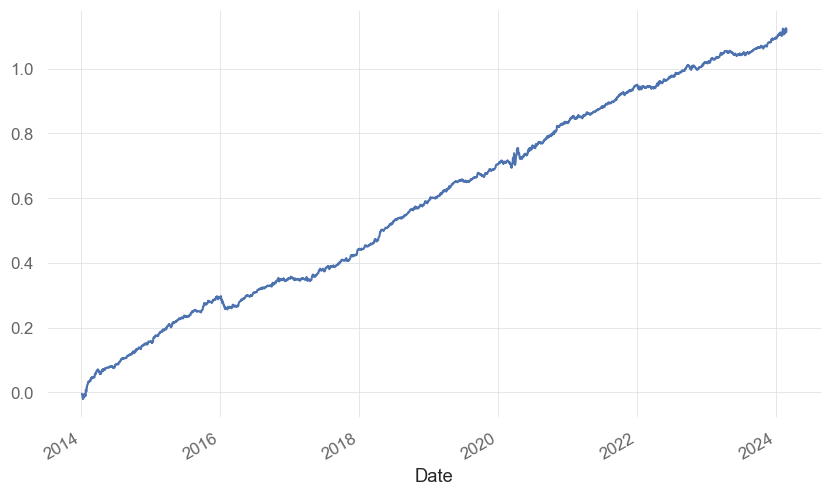

In [276]:

signal = signal_numerator[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).loc['2014':]
signal = signal.sub(signal.mean(1),0)
# signal = signal.groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)
pnl = (signal[P].shift()*R.sub(R.mean(1),0)).dropna(axis=0,how='all').sum(1).dropna()
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
print(pd.Series({'Sharpe':sr,
    'Daily Turnover (%)':turnover *100,
    'biais (bp)':pnl.mean()*1e4,
    'Sharpe since 2024' : sharpe(pnl.loc['2024':]),
    'biais  since 2024 (bp)':pnl.loc['2024':].mean()*1e4}))

In [277]:
import quantstats as qs
SP500 = qs.utils.download_returns('SPY')
pnl.index = pnl.index.tz_localize(None)
SP500.index = SP500.index.tz_localize(None)
# report with fancy (and some unuseful) stats
qs.reports.html(pnl, SP500,title = 'Strategy Dividend disconnect ')

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [270]:
SP500 , pnl  = pd.concat([SP500,pnl],axis=1).dropna().iloc[:,0], pd.concat([SP500,pnl],axis=1).dropna().iloc[:,1]

In [259]:
SP500.index = SP500.index.tz_localize(None)
SP500.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26',
               '2024-03-27', '2024-03-28'],
              dtype='datetime64[ns]', name='Date', length=7847, freq=None)